# Classifying Sonar Returns as Rocks or Mines with Gradient Boosting

In [3]:
from math import sqrt, fabs, exp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import seaborn as sns

sns.set()

In [4]:
# read data from uci data repository
data_path = './data/sonar.all-data'

# arrange data into list for labels and list of lists for attributes
x_list = []

with open(data_path) as data:
    
    for line in data:
        # split on comma
        row = line.strip().split(',')
        x_list.append(row)
        
# separate labels from attributes, convert attributes from string to numeric and convert 'M' to 1 and 'R' to 0
x_num = []
labels = []

for row in x_list:
    last_col = row.pop()
    
    if last_col == 'M':
        labels.append(1)
        
    else:
        labels.append(0)
        
    attr_row = [float(elt) for elt in row]
    x_num.append(attr_row)
    
# number of rows and columns in x matrix
n_rows = len(x_num)
n_cols = len(x_num[1])

In [5]:
# form x and y into numpy arrays and make up column names
x = np.array(x_num)
y = np.array(labels)
rock_vs_mines_names = np.array(['V' + str(i) for i in range(n_cols)])

# berak into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=531)

# instantiate model
n_est = 2000
depth = 3
learn_rate = 0.007
max_features = 20
rock_vs_mines_gbm_model = ensemble.GradientBoostingClassifier(n_estimators=n_est, max_depth=depth, 
                                                              learning_rate=learn_rate, max_features=max_features)

# train
rock_vs_mines_gbm_model.fit(x_train, y_train)

# compute auc on test set as function of ensemble size
auc = []
auc_best = 0.0
predictions = rock_vs_mines_gbm_model.staged_decision_function(x_test)

for p in predictions:
    auc_calc = roc_auc_score(y_test, p)
    auc.append(auc_calc)
    
    # capture best predictions
    if auc_calc > auc_best:
        auc_best = auc_calc
        p_best = p
        
idx_best = auc.index(max(auc))

In [6]:
# print best values
print(f'Best AUC: {auc[idx_best]}')
print(f'Number of Trees for Best AUC: {idx_best}')

Best AUC: 0.9553752535496958
Number of Trees for Best AUC: 1296


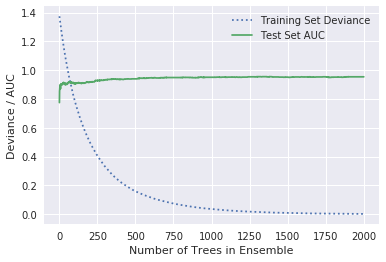

In [7]:
# plot training deviance and test AUCs vs number of trees in ensemble
plt.figure()
plt.plot(range(1, n_est + 1), rock_vs_mines_gbm_model.train_score_, label='Training Set Deviance', linestyle=':')
plt.plot(range(1, n_est + 1), auc, label='Test Set AUC')
plt.legend(loc='upper right')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Deviance / AUC')
plt.show()

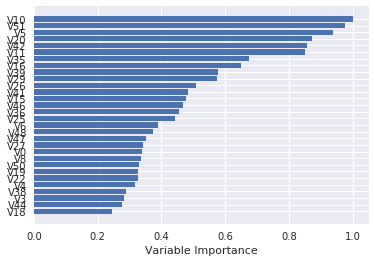

In [8]:
# Plot feature importance
feature_importance = rock_vs_mines_gbm_model.feature_importances_

# normalize by max importance
feature_importance = feature_importance/feature_importance.max()

# plot importance of top 30
idx_sorted = np.argsort(feature_importance)[30:60]

bar_pos = np.arange(idx_sorted.shape[0]) + 0.5
plt.barh(bar_pos, feature_importance[idx_sorted], align='center')
plt.yticks(bar_pos, rock_vs_mines_names[idx_sorted])
plt.xlabel('Variable Importance')
plt.show()

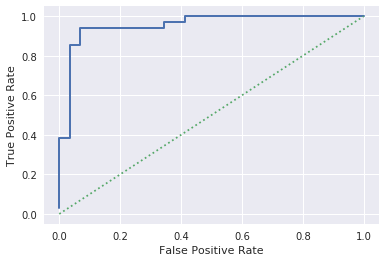

In [9]:
# plot best version of ROC curve
fpr, tpr, thresh = roc_curve(y_test, list(p_best))
ct_class = [i * 0.01 for i in range(101)]

plt.plot(fpr, tpr, linewidth=2)
plt.plot(ct_class, ct_class, linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [10]:
# pick threshold values and calc confusion matrix for best predictions
# notice that GBM predictions don't fall in range of (0, 1)
# pick threshold values at 25th, 50th, and 75th percentiles
idx_25 = int(len(thresh) * 0.25)
idx_50 = int(len(thresh) * 0.50)
idx_75 = int(len(thresh) * 0.75)

# calculate total points, total positives, and total negatives
total_pts = len(y_test)
p = sum(y_test)
n = total_pts - p

print('Confusion Matrices for Different Threshold Values')

# 25th
tp = tpr[idx_25] * p
fn = p - tp
fp = fpr[idx_25] * n
tn = n - fp

print(f'Theshold Value = {thresh[idx_25]}')
print(f'TP = {tp/total_pts}\t\t FP = {fp/total_pts}')
print(f'FN = {fn/total_pts}\t TN = {tn/total_pts}')
print('\n')

# 50th
tp = tpr[idx_50] * p
fn = p - tp
fp = fpr[idx_50] * n
tn = n - fp

print(f'Theshold Value = {thresh[idx_50]}')
print(f'TP = {tp/total_pts}\t FP = {fp/total_pts}')
print(f'FN = {fn/total_pts}\t TN = {tn/total_pts}')
print('\n')

# 75th
tp = tpr[idx_75] * p
fn = p - tp
fp = fpr[idx_75] * n
tn = n - fp

print(f'Theshold Value = {thresh[idx_75]}')
print(f'TP = {tp/total_pts}\t\t FP = {fp/total_pts}')
print(f'FN = {fn/total_pts}\t TN = {tn/total_pts}')

Confusion Matrices for Different Threshold Values
Theshold Value = 4.363824125822362
TP = 0.20634920634920634		 FP = 0.015873015873015872
FN = 0.3333333333333333	 TN = 0.4444444444444444


Theshold Value = 1.2775345900748962
TP = 0.5079365079365079	 FP = 0.031746031746031744
FN = 0.031746031746031744	 TN = 0.42857142857142855


Theshold Value = -0.2627053051801159
TP = 0.5238095238095238		 FP = 0.19047619047619047
FN = 0.015873015873015872	 TN = 0.2698412698412698
